# 2 Overfitting (8 points)

###### =========================
###### Paso 0: Paquetes
###### =========================

In [9]:
suppressPackageStartupMessages({
  if (!require(ggplot2)) install.packages("ggplot2"); library(ggplot2)
})

###### =========================
###### Paso 1: Simulación del DGP
###### =========================

In [18]:
set.seed(3324)
n <- 1000
x <- rnorm(n)
z <- 2 * ( (x - min(x)) / (max(x) - min(x)) ) - 1
beta <- 2
eps  <- rnorm(n, mean = 0, sd = 1)
y    <- beta * z + eps

###### =========================
###### Paso 2: Configuración del loop
###### =========================

In [19]:
k_list <- c(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000)

# Split 75/25 para R2 out-of-sample
set.seed(123)
idx_tr <- sample.int(n, size = floor(0.75 * n))
idx_te <- setdiff(seq_len(n), idx_tr)
n_tr <- length(idx_tr)

# TSS centrado (definición estándar)
TSS_full <- sum( (y - mean(y))^2 )

res <- data.frame(k = integer(), R2 = numeric(), AdjR2 = numeric(), R2_oos = numeric())

###### =========================
###### Paso 3: Loop sobre número de features
###### =========================

In [26]:
k_list <- c(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000)
res <- data.frame(k=integer(), R2=numeric(), AdjR2=numeric(), R2_oos=numeric())

for (k in k_list) {
  # diseño con potencias crudas de z (colnames fijos)
  X_full <- sapply(1:k, function(p) z^p)
  colnames(X_full) <- paste0("x", 1:k)

  # ---- In-sample (lm maneja rango deficiente). Sin intercepto.
  df_full <- data.frame(y = y, X_full)
  fit_full <- lm(y ~ . - 1, data = df_full)
  yhat_full <- fitted(fit_full)
  SSE_full  <- sum((y - yhat_full)^2)
  k_eff_full <- sum(!is.na(coef(fit_full)))
  R2    <- 1 - SSE_full / TSS_full
  AdjR2 <- if (n > k_eff_full) 1 - ((SSE_full/(n - k_eff_full)) / (TSS_full/(n - 1))) else NA_real_

  # ---- Out-of-sample
  # evite casos sin g.l.: requiere al menos 1 coeficiente estimable y k_eff < n_tr
  X_tr <- X_full[idx_tr, , drop = FALSE]; y_tr <- y[idx_tr]
  X_te <- X_full[idx_te, , drop = FALSE]; y_te <- y[idx_te]

  df_tr <- data.frame(y = y_tr, X_tr)
  fit_tr <- try(lm(y ~ . - 1, data = df_tr), silent = TRUE)

  if (inherits(fit_tr, "try-error")) {
    R2_oos <- NA_real_
  } else {
    coef_tr <- coef(fit_tr)
    keep <- names(coef_tr)[!is.na(coef_tr)]
    k_eff_tr <- length(keep)

    if (k_eff_tr >= 1 && k_eff_tr < n_tr && all(keep %in% colnames(X_te))) {
      # construir matriz test solo con columnas estimables
      mm_te <- as.matrix(as.data.frame(X_te)[, keep, drop = FALSE])
      yhat_te <- as.numeric(mm_te %*% coef_tr[keep])

      ybar_tr <- mean(y_tr)
      TSS_te  <- sum((y_te - ybar_tr)^2)
      SSE_te  <- sum((y_te - yhat_te)^2)
      R2_oos  <- if (TSS_te > 0) 1 - SSE_te / TSS_te else NA_real_
    } else {
      R2_oos <- NA_real_
    }
  }

  res <- rbind(res, data.frame(k = k, R2 = R2, AdjR2 = AdjR2, R2_oos = R2_oos))
}

print(res)

      k        R2     AdjR2        R2_oos
1     1 0.2967779 0.2967779  3.151321e-01
2     2 0.2975019 0.2967980  3.156084e-01
3     5 0.2989160 0.2960975  3.065766e-01
4    10 0.3020784 0.2957336  2.591770e-01
5    20 0.3096233 0.2962384 -1.138689e+04
6    50 0.3226271 0.3009344 -3.211740e+11
7   100 0.3241899 0.2996533 -2.387096e+16
8   200 0.3242855 0.2990252 -2.387096e+16
9   500 0.3242855 0.2990252 -2.387096e+16
10 1000 0.3242855 0.2990252 -2.387096e+16


###### =========================
###### Paso 4: Gráficos
###### =========================

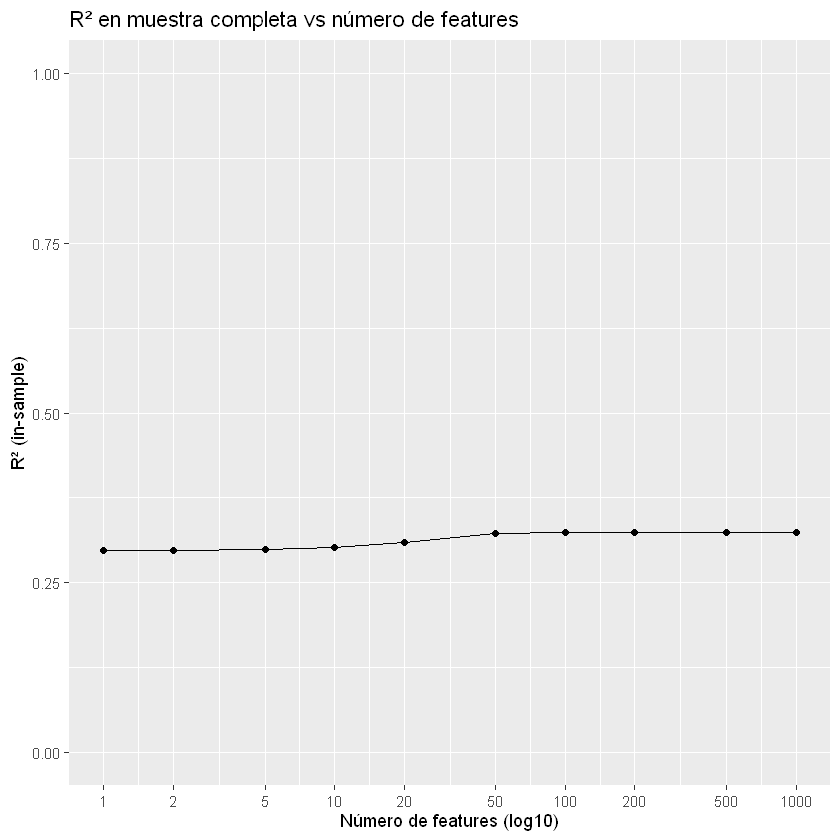

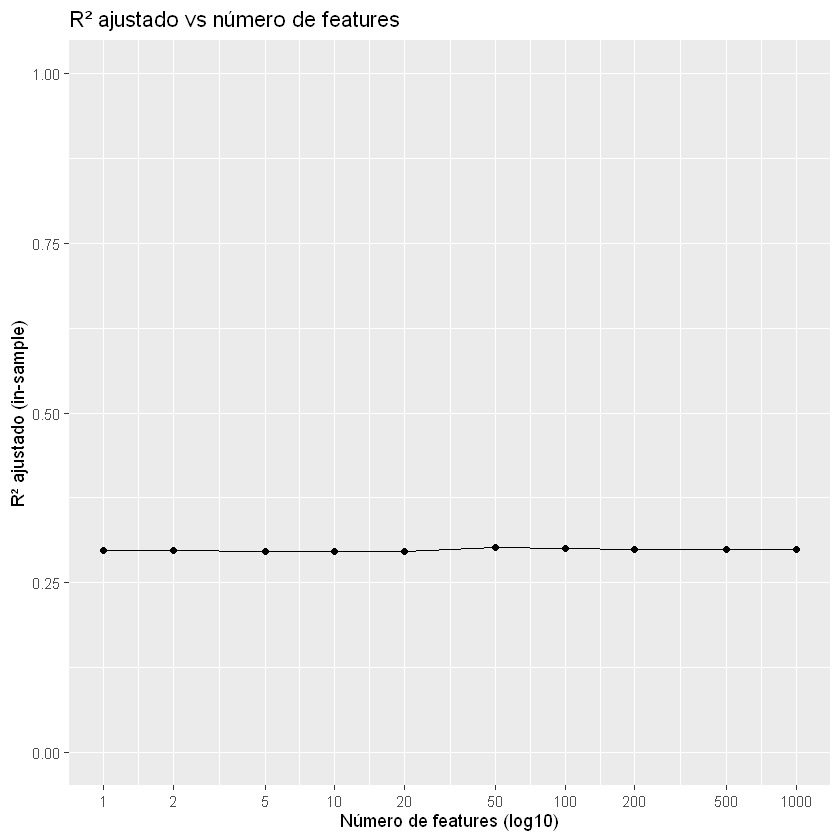

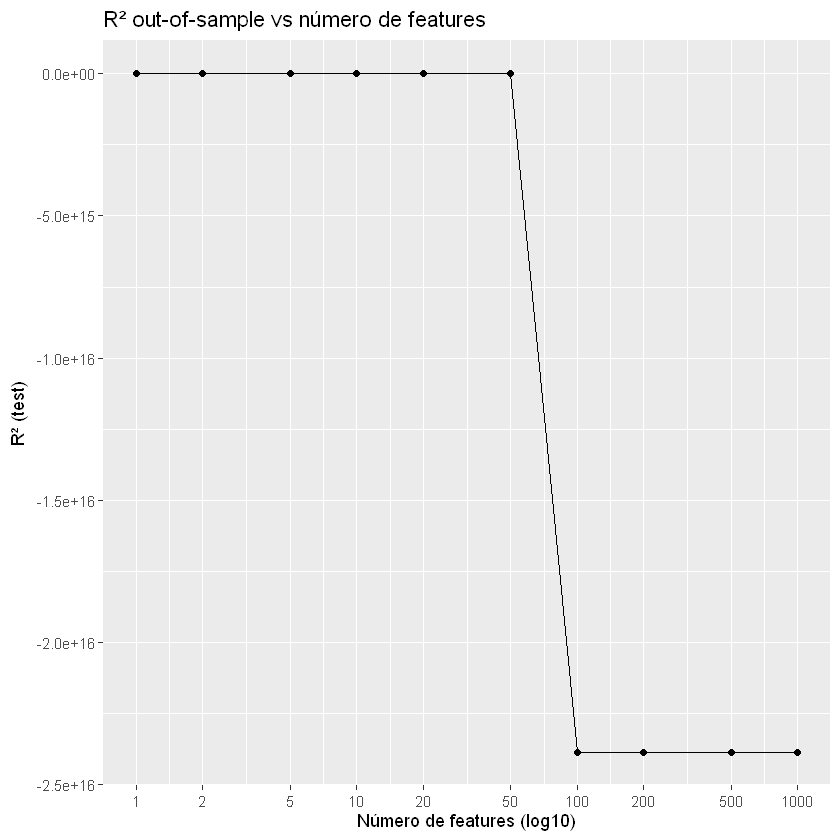

In [27]:
# Eje X en log10 para legibilidad. Y acotado a [0,1] donde aplica.
bks <- k_list

g1 <- ggplot(res, aes(x = k, y = R2)) +
  geom_line() + geom_point() +
  scale_x_continuous(trans = "log10", breaks = bks) +
  coord_cartesian(ylim = c(0, 1)) +
  labs(title = "R² en muestra completa vs número de features",
       x = "Número de features (log10)", y = "R² (in-sample)")

g2 <- ggplot(res, aes(x = k, y = AdjR2)) +
  geom_line() + geom_point(na.rm = TRUE) +
  scale_x_continuous(trans = "log10", breaks = bks) +
  coord_cartesian(ylim = c(0, 1)) +
  labs(title = "R² ajustado vs número de features",
       x = "Número de features (log10)", y = "R² ajustado (in-sample)")

g3 <- ggplot(res, aes(x = k, y = R2_oos)) +
  geom_line(na.rm = TRUE) + geom_point(na.rm = TRUE) +
  scale_x_continuous(trans = "log10", breaks = bks) +
  labs(title = "R² out-of-sample vs número de features",
       x = "Número de features (log10)", y = "R² (test)")

print(g1); print(g2); print(g3)

# 3.Real data (9 points)

In [35]:
library(readr)
df <- read_csv("C:/Users/User/Desktop/High_Dimensional_Linear_Models/apartments.csv",
               show_col_types = FALSE)
ncol(df)  # debería dar 21


[1] 21

In [44]:
df


id,price,month,area,type,rooms,centredistance,schooldistance,clinicdistance,postofficedistance,⋯,end_0,end_1,end_2,end_3,end_4,end_5,end_6,end_7,end_8,end_9
<chr>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
a01d82c9529f98a54d64b9e061c9a73b,1199999,1,105,apartmentBuilding,4,5.06,1.080,0.949,0.623,⋯,0,0,0,0,0,1,0,0,0,0
8373aa373dbc3fe7ca3b7434166b8766,650000,1,73,tenement,3,3.24,0.275,0.672,0.367,⋯,0,0,0,1,0,0,0,0,0,0
7d0c31d5409caab173571cce3dcdf702,590000,1,69,blockOfFlats,3,3.94,0.139,1.336,0.926,⋯,0,0,0,0,0,0,0,0,0,1
3eaa36a59b9354206703b5f6b2f2ff1d,584999,1,42,blockOfFlats,2,5.19,0.209,1.533,0.201,⋯,0,0,1,0,0,0,0,0,0,0
027b30cebbc49faf3094421b741ddd56,363000,1,46,blockOfFlats,2,1.65,0.250,0.624,0.510,⋯,0,0,0,0,0,0,1,0,0,0
27437e173a8c37d5002c0bf69c848b7c,717000,1,81,tenement,3,1.76,0.083,0.257,0.294,⋯,0,1,0,0,0,0,0,0,0,0
39404087c054348c27522c74ca21a973,689000,1,70,blockOfFlats,3,3.35,0.269,1.364,0.247,⋯,1,0,0,0,0,0,0,0,0,0
7a3b00507c086fcf83562f22bb5d01fc,790000,1,67,apartmentBuilding,3,1.61,0.501,0.973,0.713,⋯,0,0,0,0,0,0,0,1,0,0
24af7cc54099d7930535543827604a9d,560000,1,69,blockOfFlats,3,2.29,0.371,0.592,0.213,⋯,0,0,0,0,0,0,0,0,0,1


# Sección de Limpieza

## Pregunta 1: Creación de la cuadrática del área (0.25 pts)

In [45]:
df$area2 <- df$area^2


## Pregunta 2: Conversión en Dummies (0.75 pts)

#### Descripción de DATA

In [ ]:
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
library(dplyr)

In [46]:
cols <- c("hasparkingspace","hasbalcony","haselevator","hassecurity","hasstorageroom")

# Resumen
t <- tibble(variable = cols) |>
  mutate(
    eltype      = sapply(df[cols], function(x) paste(class(x), collapse = "/")),
    nmissing    = sapply(df[cols], function(x) sum(is.na(x))),
    pct_missing = round(100 * sapply(df[cols], function(x) mean(is.na(x))), 2),
    nunique     = sapply(df[cols], function(x) dplyr::n_distinct(x, na.rm = TRUE))
  )
t


variable,eltype,nmissing,pct_missing,nunique
<chr>,<chr>,<int>,<dbl>,<int>
hasparkingspace,integer,0,0.00,2
hasbalcony,integer,0,0.00,2
haselevator,integer,5333,4.84,2
hassecurity,integer,0,0.00,2
hasstorageroom,integer,0,0.00,2


#### Reemplazo a Dummies

In [47]:
to01_keepmiss <- function(x){
  if (is.character(x)) return(ifelse(is.na(x), NA_integer_, as.integer(tolower(x) == "yes")))
  if (is.logical(x))   return(ifelse(is.na(x), NA_integer_, as.integer(x)))
  if (is.numeric(x))   return(ifelse(is.na(x), NA_integer_, as.integer(x != 0)))
  # fallback
  u <- suppressWarnings(as.numeric(x))
  ifelse(is.na(u), NA_integer_, as.integer(u != 0))
}

df[cols] <- lapply(df[cols], to01_keepmiss)

### Pregunta 3: Obtención de la última cifra del área (1 pts)

In [48]:
# Última cifra del área
lastdigit_area <- function(x){
  v <- suppressWarnings(as.numeric(x))
  out <- rep(NA_integer_, length(v))
  ok <- !is.na(v)
  out[ok] <- abs(floor(v[ok])) %% 10L
  out
}
ld <- lastdigit_area(df$area)

# Dummies end_0 ... end_9 (NA -> 0)
for (d in 0:9) {
  df[[paste0("end_", d)]] <- as.integer(!is.na(ld) & ld == d)
}


### Pregunta 4: Modelo de Estimación Lineal

In [49]:
# 0) Categóricas
df$month            <- factor(df$month)
df$type             <- factor(df$type)
df$rooms            <- factor(df$rooms)
df$ownership        <- factor(df$ownership)
df$buildingmaterial <- factor(df$buildingmaterial)

In [50]:
# 1) Columnas para el modelo
end_terms  <- paste0("end_", 0:8)  # omite end_9 (base)
dist_cols  <- c("centredistance","schooldistance","clinicdistance","postofficedistance",
                "kindergartendistance","restaurantdistance","collegedistance","pharmacydistance")
all_cols   <- c("price","area","area2", dist_cols, end_terms,
                "month","type","rooms","ownership","buildingmaterial")

In [51]:
# 2) Filtra missings solo en variables usadas
dfreg <- df[complete.cases(df[, all_cols]), ]

In [52]:
# 3) Fórmula y OLS (base = end_9)
f_full <- as.formula(
  paste0("price ~ area + area2 + ",
         paste(dist_cols, collapse = " + "), " + ",
         paste(end_terms, collapse = " + "), " + ",
         "month + type + rooms + ownership + buildingmaterial")
)

m_full <- lm(f_full, data = dfreg)

In [53]:
comment_end0 <- function(m){
  coefs <- summary(m)$coefficients
  if (!"end_0" %in% rownames(coefs)) stop("end_0 no está en el modelo.")
  beta <- coefs["end_0", 1]
  se   <- coefs["end_0", 2]
  t    <- beta / se
  p    <- 2 * pt(abs(t), df = df.residual(m), lower.tail = FALSE)
  sig  <- if (p < 0.05) "estadísticamente significativo" else "no estadísticamente significativo"
  cat(sprintf(
    "Controlando por área, área², distancias y dummies (mes, tipo, rooms, propiedad, material),\n",
    NULL))
  cat(sprintf("tener último dígito 0 se asocia con un precio %.2f mayor que el dígito 9. Efecto %s.\n",
              beta, sig))
}
comment_end0(m_full)

tener último dígito 0 se asocia con un precio 24415.20 mayor que el dígito 9. Efecto estadísticamente significativo.


### Pregunta 5: Partición

In [54]:
# B) FWL
controls <- c("area","area2", dist_cols, paste0("end_", 1:8),
              "month","type","rooms","ownership","buildingmaterial")

f_y <- as.formula(paste("price ~", paste(controls, collapse = " + ")))
f_d <- as.formula(paste("end_0 ~",  paste(controls, collapse = " + ")))

r_y <- resid(lm(f_y, data = dfreg))
r_d <- resid(lm(f_d, data = dfreg))

m_fwl <- lm(r_y ~ 0 + r_d) 

In [55]:
# C) Tablas y verificación
tidy_ct <- function(m){
  co <- summary(m)$coefficients
  data.frame(
    Term     = rownames(co),
    Coef     = round(co[,1], 3),
    StdError = round(co[,2], 3),
    t        = round(co[,3], 2),
    p        = formatC(co[,4], format = "e", digits = 2),
    row.names = NULL
  )
}

cat("=== OLS completo ===\n");  print(tidy_ct(m_full))
cat("=== FWL (parcial) ===\n"); print(tidy_ct(m_fwl))

beta_full <- coef(m_full)["end_0"]; se_full <- summary(m_full)$coefficients["end_0","Std. Error"]
beta_fwl  <- coef(m_fwl)["r_d"];    se_fwl  <- summary(m_fwl)$coefficients["r_d","Std. Error"]

cat(sprintf("\nend_0 OLS: β=%.6f  se=%.6f\n", beta_full, se_full))
cat(sprintf("end_0 FWL: β=%.6f  se=%.6f\n", beta_fwl,  se_fwl))
cat("coef iguales: ", isTRUE(all.equal(beta_full, beta_fwl,  tolerance = 1e-10)), "\n")
cat("se   iguales: ", isTRUE(all.equal(se_full,  se_fwl,   tolerance = 1e-10)), "\n")

=== OLS completo ===
                           Term        Coef   StdError      t         p
1                   (Intercept)  296654.044  12782.090  23.21 1.26e-118
2                          area   11105.480    396.066  28.04 7.17e-172
3                         area2      17.812      2.534   7.03  2.10e-12
4                centredistance   24132.442    629.580  38.33 1.46e-317
5                schooldistance   43361.914   6254.727   6.93  4.17e-12
6                clinicdistance  -65433.681   2156.176 -30.35 9.53e-201
7            postofficedistance    8905.804   5278.802   1.69  9.16e-02
8          kindergartendistance   22503.942   6435.840   3.50  4.71e-04
9            restaurantdistance -278991.091   6327.079 -44.09  0.00e+00
10              collegedistance  -31794.869   1658.439 -19.17  1.13e-81
11             pharmacydistance  126584.813   7504.857  16.87  1.11e-63
12                        end_0   24415.202   5906.292   4.13  3.57e-05
13                        end_1   -8717.603

#### Price premium for area that ends in 0-digit

### 1. Entrenamiento del modelo (1.25 pts)

In [56]:
dist_cols <- c("centredistance","schooldistance","clinicdistance","postofficedistance",
               "kindergartendistance","restaurantdistance","collegedistance","pharmacydistance")
end_terms <- paste0("end_", 1:8)
vars <- c("price","area","area2", dist_cols, end_terms,
          "month","type","rooms","ownership","buildingmaterial")


In [57]:
for (v in c("month","type","rooms","ownership","buildingmaterial")) df[[v]] <- factor(df[[v]])

train <- subset(df, end_0 == 0)
train <- train[complete.cases(train[, vars]), ]

f_train <- as.formula(
  paste0("price ~ area + area2 + ",
         paste(dist_cols, collapse=" + "), " + ",
         paste(end_terms, collapse=" + "), " + ",
         "month + type + rooms + ownership + buildingmaterial")
)

m_train <- lm(f_train, data = train)


### 2. Predecir Precios (1.25 pts)

In [58]:
vars_pred <- c("area","area2", dist_cols, end_terms,
               "month","type","rooms","ownership","buildingmaterial")
df_pred <- df[complete.cases(df[, vars_pred]), ]
df_pred$pred_price <- predict(m_train, newdata = df_pred)
df_pred$err <- df_pred$price - df_pred$pred_price

### 3. Comparar Promedios (0.50 pts)

In [59]:
g <- subset(df_pred, end_0 == 1 & !is.na(price) & !is.na(pred_price))

if (nrow(g) == 0) {
  message("No hay filas end_0==1 con predicción disponible.")
} else {
  mu_y    <- mean(g$price)
  mu_yhat <- mean(g$pred_price)
  prem    <- mu_y - mu_yhat
  prem_pct<- 100 * prem / mu_yhat

  print(data.frame(
    N = nrow(g),
    avg_price = round(mu_y, 2),
    avg_pred  = round(mu_yhat, 2),
    premium   = round(prem, 2),
    premium_pct = round(prem_pct, 2)
  ))

  cat(if (prem > 0)
        sprintf("Hipótesis: se venden por ENCIMA del modelo (≈ %.2f%%).\n", prem_pct)
      else
        sprintf("Hipótesis: NO superan al modelo (≈ %.2f%%).\n", prem_pct))
}


     N avg_price avg_pred  premium premium_pct
1 6844  896553.1   871809 24744.11        2.84
Hipótesis: se venden por ENCIMA del modelo (≈ 2.84%).
